# P4 - PREDICTION CONSOMMATION ELECTRIQUE DE BATIMENTS

<p><strong>Contexte :</strong> Le client <strong>"Ville de Seattle"</strong> souhaite atteindre son objectif de ville neutre en émissions de carbone d'ici 2050 et nous a missionner pour étudier les émissions des bâtiments <strong>non destinés à l’habitation</strong>.</p>

<p><strong>Problématique :</strong> Des relevés minutieux des consommations électriques ont été ainsi effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir.</p>

<p><strong>Objectifs :</strong></p>

<ul>
    <li>A partir de ces relevés, réaliser une <strong>prédiction</strong> des émissions de CO2 et de la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.</li>
    <li>Evaluer l’intérêt de l’<strong>ENERGY STAR Score</strong> pour la prédiction d’émissions, qui est fastidieux à calculer.</li>
</ul>

<hr/>

# *Partie 1 : Exploration des données*

<hr/>

## I. Importation des Librairies utiles

Ici on importe les librairies utilisés tout au long de l'étude.

In [1]:
# librairies pour ne pas montrer les warnings
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# librairies pour les graphes
%matplotlib  inline
import matplotlib.pyplot as plt
import seaborn as sns

# librairies pour les analyses
import pandas as pd
import numpy as np
import missingno as msno
import math
from scipy import stats

from mlxtend.preprocessing import standardize
from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.plotting import plot_pca_correlation_graph

# librairies pour les modèles
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

<hr />

## II. Importation des données
<p> Ici on importe les données à partir des fichiers .csv téléchargés sur le site de la Banque Mondiale. </p>

* **2015**

In [2]:
# importation des jeux de données à partir de .csv
df_2015 = pd.read_csv('../Dataset/2015-building-energy-benchmarking.csv')
df_2015.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [3]:
df_2015.shape

(3340, 47)

* **2016**

In [4]:
# importation des jeux de données à partir de .csv
df_2016 = pd.read_csv('../Dataset/2016-building-energy-benchmarking.csv')
df_2016.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86


In [5]:
df_2016.shape

(3376, 46)

* **Concatenation 2015 et 2016**

In [6]:
# liste des colonnes retrouvées dans df_2015 et pas dans df_2016
[col for col in df_2015.columns if col not in df_2016.columns]

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [7]:
# liste des colonnes retrouvées dans df_2015 et pas dans df_2016
[col for col in df_2016.columns if col not in df_2015.columns]

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

**Observation :** On note des colonnes semblables dans les 2 df mais avec des noms différents.
<p> => parse la colonne Location dans df_2015 en plusieurs colonnes présentes dans df_2016</p>
<p> => redéfinition des noms des colonnes de df_2015 en les noms des colonnes correspondantes dans df_2016</p>

In [8]:
for i in df_2015.index:
    # pour chaque ligne, parse la colonne "Location" en plusieurs colonnes vues dans df_2016
    
    location = eval(df_2015.loc[i,'Location']) # eval : converti string en dict
    adresse = eval(location['human_address'])
    df_2015.loc[i,'Address'] = adresse['address']
    df_2015.loc[i,'City'] = adresse['city']
    df_2015.loc[i,'State'] = adresse['state']
    df_2015.loc[i,'ZipCode'] = float(adresse['zip'])
    df_2015.loc[i,'Latitude'] = location['latitude']
    df_2015.loc[i,'Longitude'] = location['longitude']

In [9]:
df_2015.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Address,City,State,ZipCode,Latitude,Longitude
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,14.0,NaN,31.0,18081,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61219025,-122.33799744


In [10]:
# changement des noms de colonnes de df_2015 avec les noms de colonnes de df_2016
df_2015 = df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                        'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',
                        'Comment': 'Comments'
                       })

In [11]:
# concatenation des 2 jeux de données
df_all = df_2015.append(df_2016, ignore_index=True, sort=False)

In [12]:
# creation de colonnes à partir d'autres informations :
for i in df_all.index: 
    df_all.loc[i,'Age'] = df_all.loc[i,'DataYear'] - df_all.loc[i,'YearBuilt']
    adresse = df_all.loc[i,'Address'].split(' ')[1:]
    df_all.loc[i,'Street'] = ' '.join(adresse)

In [13]:
df_all.Street.nunique()

2234

In [14]:
df_all.ZipCode.nunique()

55

In [15]:
df_all.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,SPD Beats,Zip Codes,Address,City,State,ZipCode,Latitude,Longitude,Age,Street
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,31.0,18081.0,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61219025,-122.33799744,88.0,OLIVE WAY
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,31.0,18081.0,724 PINE ST,SEATTLE,WA,98101.0,47.61310583,-122.33335756,19.0,PINE ST


In [16]:
df_all.shape

(6716, 55)

In [17]:
list(df_all.BuildingType.unique())

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [18]:
df_all = df_all[~df_all.BuildingType.str.contains('family')].reset_index(drop=True)

In [19]:
df_all.shape

(3318, 55)

In [20]:
list(df_all.BuildingType.unique())

['NonResidential',
 'Nonresidential COS',
 'SPS-District K-12',
 'Campus',
 'Nonresidential WA']

<hr/>

## III. Selection des données
<p> Ici on sélectionne les données à partir du nom des colonnes qu'on pense utiles à l'étude. </p>

In [21]:
selected_col = ['OSEBuildingID', 'BuildingType', 'DataYear','Age', 'Street', 'ZipCode',
                'PrimaryPropertyType', 'LargestPropertyUseType', 'Neighborhood',
                'NumberofBuildings', 'NumberofFloors',
                'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',                
                'ENERGYSTARScore',
                'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
                'TotalGHGEmissions', 'GHGEmissionsIntensity']

In [22]:
df = df_all[selected_col]

In [23]:
df.head()

,OSEBuildingID,BuildingType,DataYear,Age,Street,ZipCode,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,NumberofBuildings,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,2015,88.0,OLIVE WAY,98101.0,Hotel,Hotel,DOWNTOWN,1.0,...,65.0,78.9,173.5,6981428.0,2023032.0,3686160.0,1272388.0,0.0,249.43,2.64
1,2,NonResidential,2015,19.0,PINE ST,98101.0,Hotel,Hotel,DOWNTOWN,1.0,...,51.0,94.4,191.3,8354235.0,0.0,3905411.0,4448985.0,0.0,263.51,2.38
2,3,NonResidential,2015,46.0,5TH AVE,98101.0,Hotel,Hotel,DOWNTOWN,1.0,...,18.0,96.6,242.7,73130656.0,19660404.0,49762435.0,3709900.0,0.0,2061.48,1.92
3,5,NonResidential,2015,89.0,STEWART ST,98101.0,Hotel,Hotel,DOWNTOWN,1.0,...,1.0,460.4,636.3,28229320.0,23458518.0,2769023.0,2001894.0,0.0,1936.34,31.38
4,8,NonResidential,2015,35.0,LENORA ST,98121.0,Hotel,Hotel,DOWNTOWN,1.0,...,67.0,120.1,228.8,14829099.0,0.0,6066245.0,8763105.0,0.0,507.70,4.02


In [24]:
df.shape

(3318, 24)

<hr/>

## IV. Observation des données
<p> Ici on regarde l'allure des données. </p>

* **Récupération des infos du jeu de données**

In [25]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318 entries, 0 to 3317
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3318 non-null   int64  
 1   BuildingType            3318 non-null   object 
 2   DataYear                3318 non-null   int64  
 3   Age                     3318 non-null   float64
 4   Street                  3318 non-null   object 
 5   ZipCode                 3302 non-null   float64
 6   PrimaryPropertyType     3318 non-null   object 
 7   LargestPropertyUseType  3247 non-null   object 
 8   Neighborhood            3318 non-null   object 
 9   NumberofBuildings       3316 non-null   float64
 10  NumberofFloors          3310 non-null   float64
 11  PropertyGFATotal        3318 non-null   int64  
 12  PropertyGFAParking      3318 non-null   int64  
 13  PropertyGFABuilding(s)  3318 non-null   int64  
 14  ENERGYSTARScore         2211 non-null   

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


* **Observation des taux de remplissage des colonnes**

In [26]:
def visu_nan(dataframe):
    ''' Fonction qui prend en entrée un dataframe et retourne deux figures : 
           - une visualisation des valeurs manquantes sous forme de matrice
           - une visualisation du taux de remplissage des colonnes sous forme de barplot
    '''
    
    fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(25,10))
    msno.matrix(dataframe,ax=ax1)
    nullity_counts = len(dataframe) - dataframe.isnull().sum()
    (nullity_counts / len(dataframe)).plot.bar(ax=ax2,color='gray')

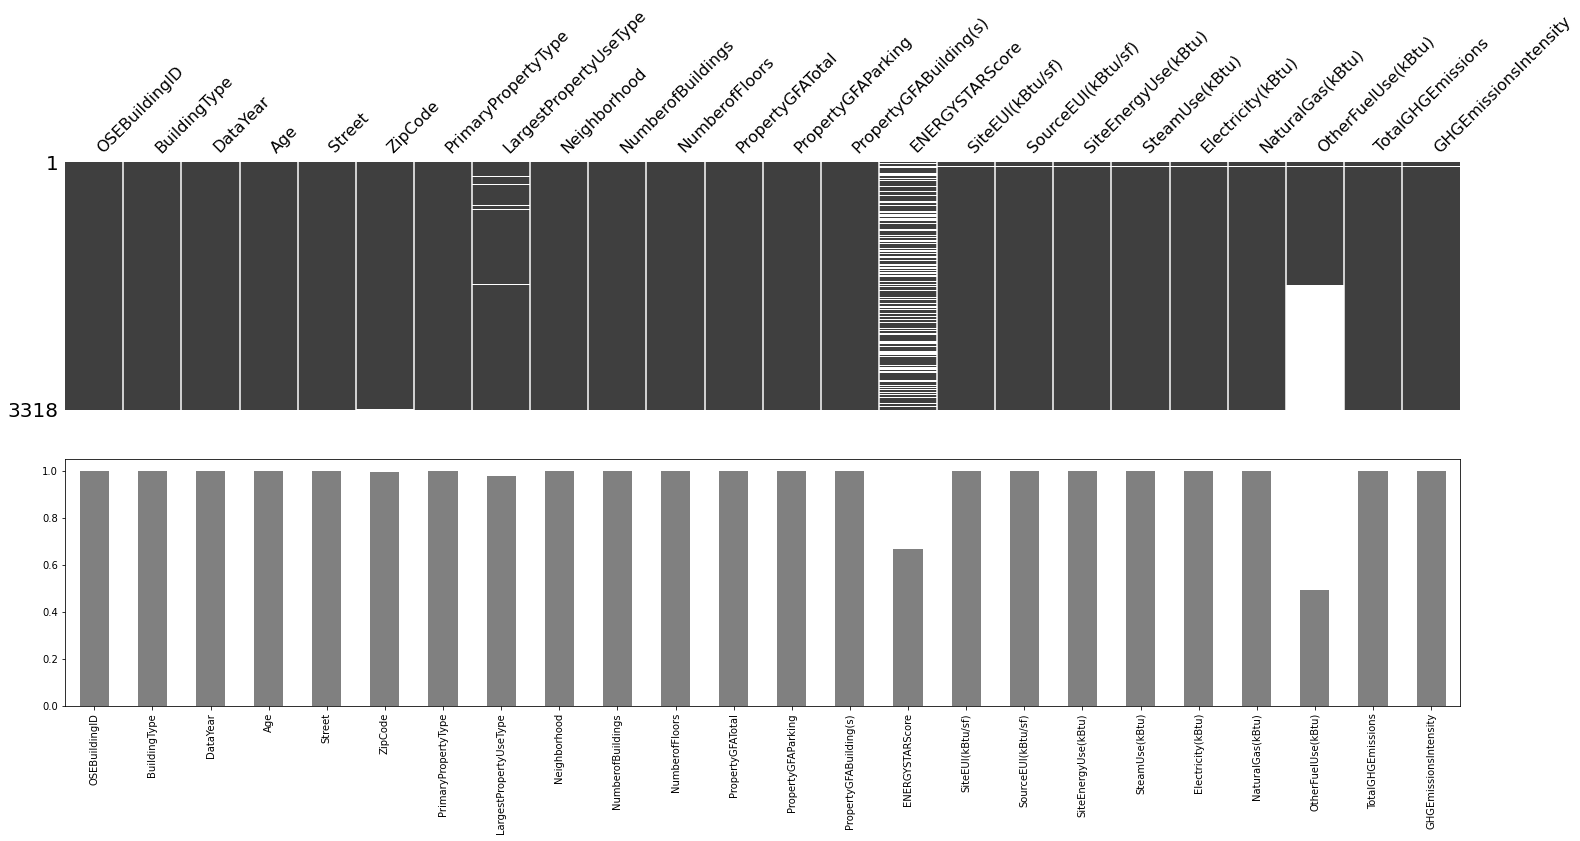

In [27]:
visu_nan(df)

* **Identification et suppression des colonnes dont le taux de remplissage <= 50%**

In [28]:
# liste des colonnes ayant un taux de remplissage > 50%
col_to_cancel = [col for col in df.columns if ((len(df) - df[col].isnull().sum())/len(df))<=0.5]

In [29]:
col_to_cancel

['OtherFuelUse(kBtu)']

In [30]:
df = df.drop(col_to_cancel, axis=1)

* **Analyse des variables restants**

Les variables catégorielles :

In [31]:
cat = [col for col in df.columns if (df[col].dtypes=='object')]
cat.extend(['OSEBuildingID','DataYear','ZipCode'])

Les variables numériques :

In [32]:
var = [col for col in df.columns if (col not in ['OSEBuildingID','DataYear','ZipCode']) & ((df[col].dtypes=='float64') | (df[col].dtypes=='int64'))]

In [33]:
def box_plot(dataframe):
    ''' Fonction qui prend en entrée un dataframe 
        et retourne pour chaque variable numerique son boxplot
    '''
    
    num_columns = var
    medianprops = dict(linestyle='-.', linewidth=2.5, color='green')
    meanpointprops = dict(marker='D',markerfacecolor='red',markeredgecolor='red',markersize=8)
    
    fig = plt.figure(figsize=(24,12))
    for i in range(len(num_columns)):
        data = dataframe[num_columns[i]]
        filtered_data = data[~np.isnan(data)]
        
        plt.subplot(3, 6, i+1)
        plt.boxplot(filtered_data,showmeans=True,medianprops=medianprops,meanprops=meanpointprops)
        plt.xticks(ticks=[1],labels=[num_columns[i]])

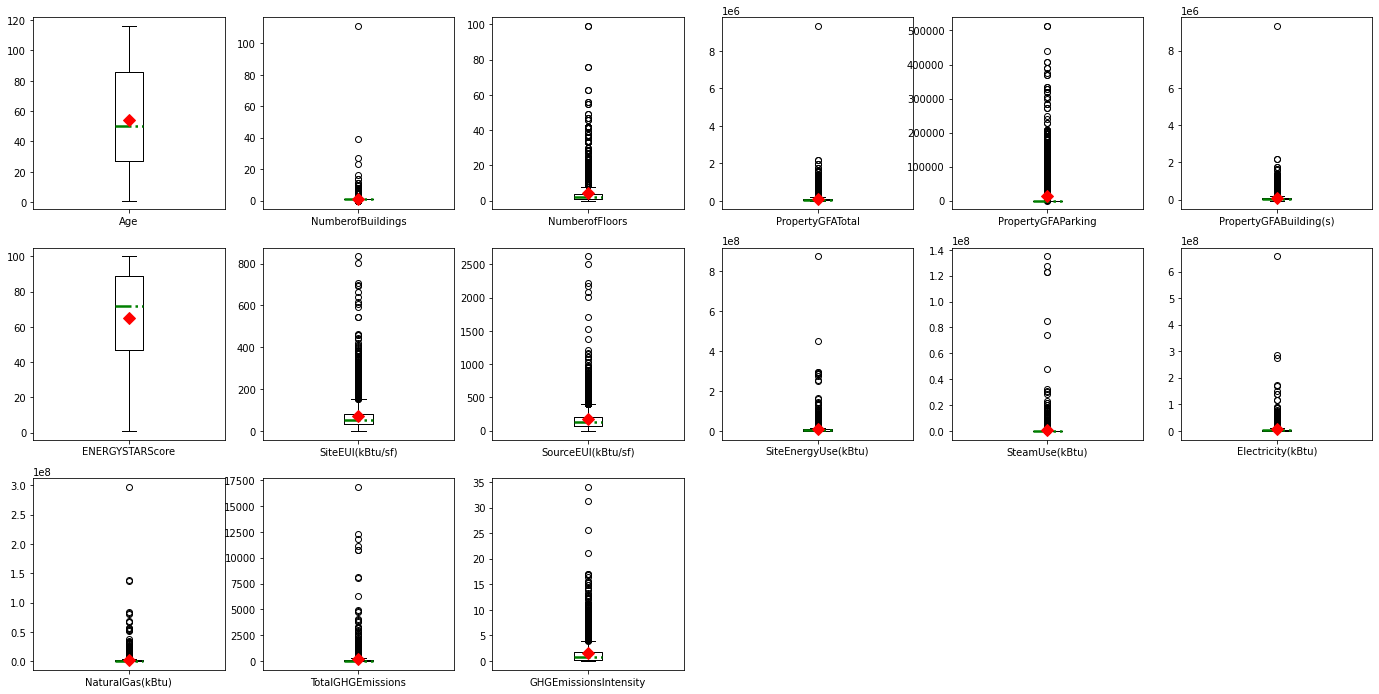

In [34]:
box_plot(df)

* **Proportion de bâtiments présents sur les deux années 2015-2016**

In [35]:
bat = df.OSEBuildingID.unique()
bat_15 = df.OSEBuildingID[df.DataYear==2015].unique()
bat_16 = df.OSEBuildingID[df.DataYear==2016].unique()

In [36]:
bat_56 = [b for b in bat if (b in bat_15) & (b in bat_16)]
bat_5 = [b for b in bat_15 if b not in bat_56]
bat_6 = [b for b in bat_16 if b not in bat_56]

In [37]:
print('Nombre total de Bâtiments (les 2 années confondus) : ' + str(len(bat)))
print('Proportion de Bâtiments présents sur les 2 années : ' + str(100*len(bat_56)/len(bat)) + '%')
print('Proportion de Bâtiments présents uniquement sur 2015 : ' + str(100*len(bat_5)/len(bat)) + '%')
print('Proportion de Bâtiments présents uniquement sur 2016 : ' + str(100*len(bat_6)/len(bat)) + '%')

Nombre total de Bâtiments (les 2 années confondus) : 1698
Proportion de Bâtiments présents sur les 2 années : 95.40636042402826%
Proportion de Bâtiments présents uniquement sur 2015 : 1.7667844522968197%
Proportion de Bâtiments présents uniquement sur 2016 : 2.8268551236749118%


<hr/>

## V. Gestion des outliers
<p> Ici on traite et gère les outliers. </p>

In [38]:
def iqr(tab):
    ''' Fonction qui prend en entrée un tableau,
        et retourne les limites basses et hautes des moustaches des données
    '''    
    Q1 = tab.quantile(0.25)
    Q3 = tab.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - (1.5 * IQR)
    Upper_Whisker = Q3 + (1.5 * IQR)
    
    return (Lower_Whisker,Upper_Whisker)

In [39]:
outliers = pd.DataFrame(index = var)

for col in var:
    outliers.loc[col,'nonnull_count'] = df[col].count()
    
    Lower_Whisker,Upper_Whisker = iqr(df[col])
    n_outlier_i = len(df[(df[col]<Lower_Whisker) | (df[col]>Upper_Whisker)])
    outliers.loc[col,'iqr_count'] = n_outlier_i
    outliers.loc[col,'iqr_%'] = 100*n_outlier_i/df[col].count()

    zscores = pd.DataFrame(stats.zscore(df[col],nan_policy='omit'),columns=['value'])
    n_outlier_z = len(zscores[(zscores.value> 3) | (zscores.value < -3)])
    outliers.loc[col,'zscore_count'] = n_outlier_z
    outliers.loc[col,'zscore_%'] = 100*n_outlier_z/df[col].count()

In [40]:
outliers

,nonnull_count,iqr_count,iqr_%,zscore_count,zscore_%
Age,3318.0,0.0,0.000000,0.0,0.000000
NumberofBuildings,3316.0,118.0,3.558504,14.0,0.422195
NumberofFloors,3310.0,271.0,8.187311,72.0,2.175227
PropertyGFATotal,3318.0,397.0,11.965039,51.0,1.537071
PropertyGFAParking,3318.0,679.0,20.464135,89.0,2.682339
PropertyGFABuilding(s),3318.0,355.0,10.699216,47.0,1.416516
ENERGYSTARScore,2211.0,0.0,0.000000,0.0,0.000000
SiteEUI(kBtu/sf),3308.0,305.0,9.220073,68.0,2.055623
SourceEUI(kBtu/sf),3309.0,268.0,8.099124,57.0,1.722575
SiteEnergyUse(kBtu),3309.0,365.0,11.030523,27.0,0.815956


In [41]:
def outlier_treat(dataframe,mode,variables=var):
    ''' Fonction qui prend en entrée un dataframe,
        pour chaque variable quantitative identifie les outliers (valeurs en dehors de la distribution),
        les remplaces par la valeur NaN,
        et retourne le dataframe après traitement
    '''
    
    res = dataframe.copy()
    index_outlier = []
    
    for col in variables:
        if mode=='IQR':
            Lower_Whisker,Upper_Whisker = iqr(dataframe[col])
            index_outlier.extend(res[(res[col]<Lower_Whisker) | (res[col]>Upper_Whisker)].index)
            
        elif mode=='ZSCORE':
            zscores = pd.DataFrame(stats.zscore(dataframe[col],nan_policy='omit'),columns=['value'])
            index_outlier.extend(zscores[(zscores.value>3) | (zscores.value<-3)].index)
    
    index_outlier = list(dict.fromkeys(index_outlier) ) 
    res.drop(index_outlier,inplace=True)
    
    return res

In [42]:
data_iqr = outlier_treat(df,mode='IQR')
data_z = outlier_treat(df,mode='ZSCORE')

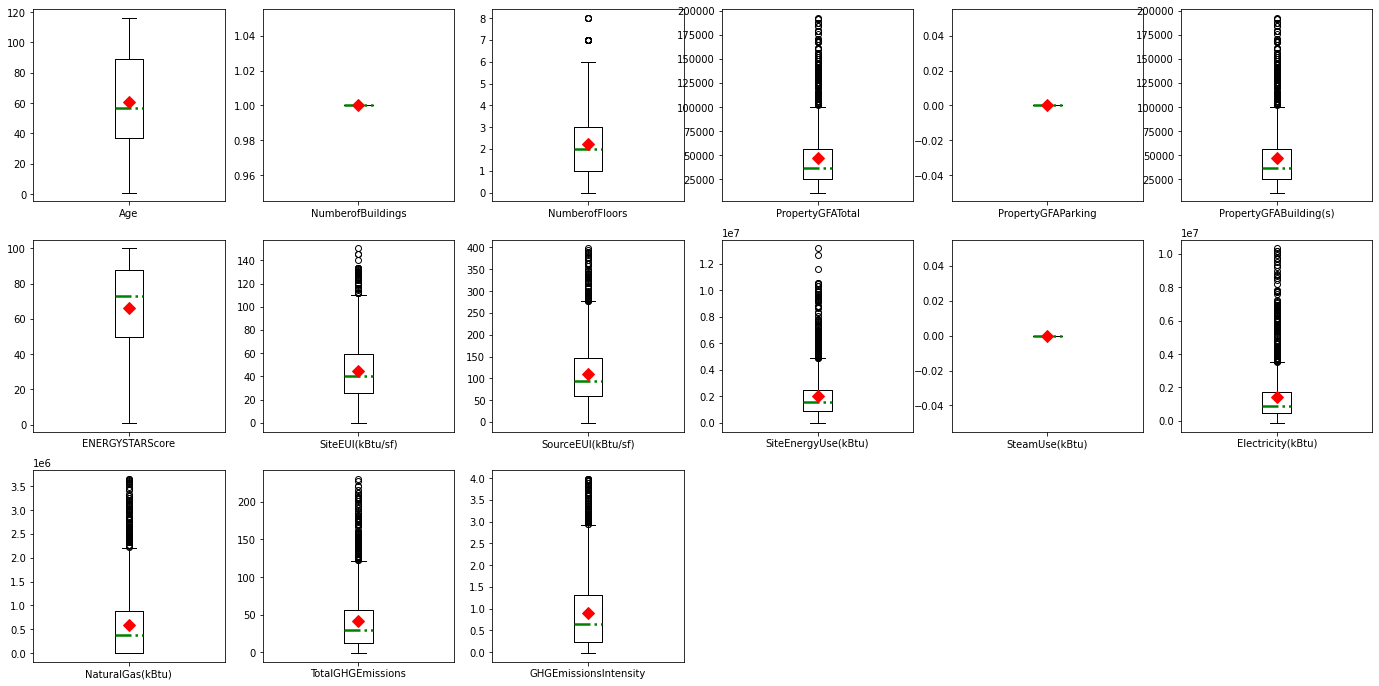

In [43]:
box_plot(data_iqr)

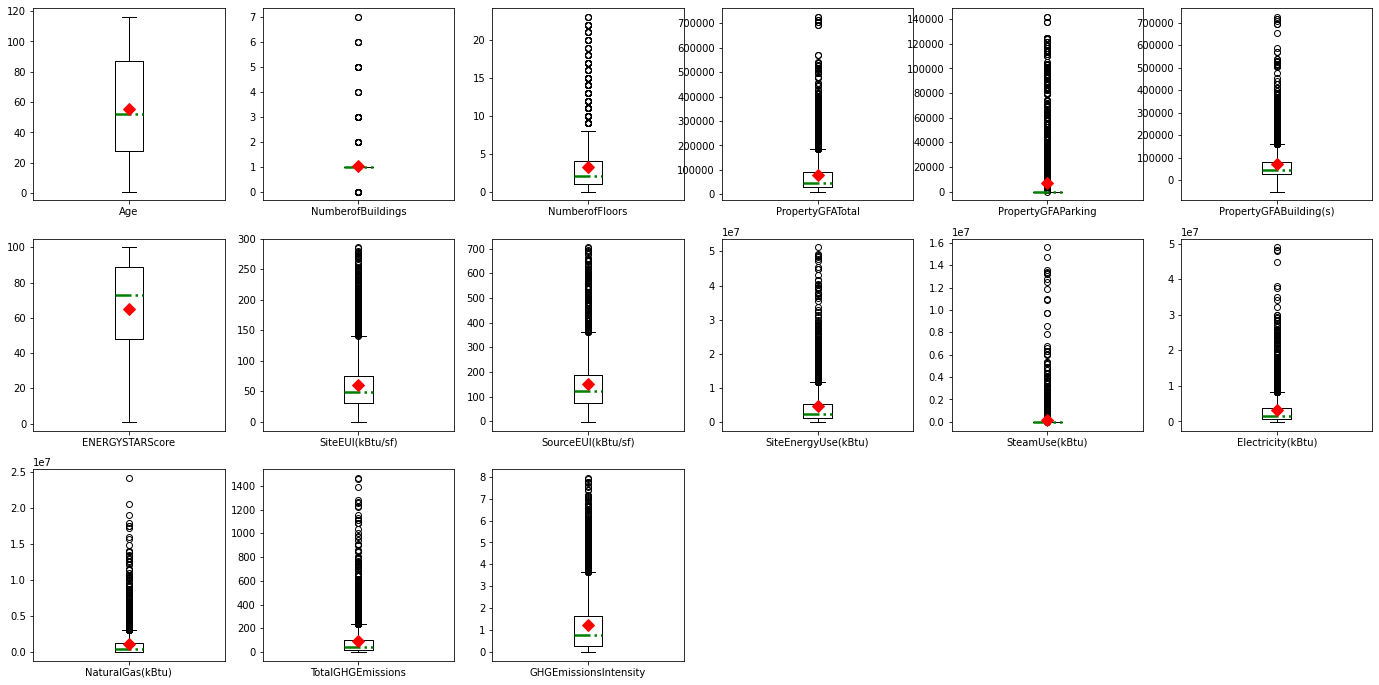

In [44]:
box_plot(data_z)

***Observation :***
<p> On note que la gestion des outliers avec le Zscore est plus pertinente (moins de perte de données).</p>
<p> On utilisera cette méthode, néanmoins elle ne sera pas appliquée à toutes les variables.</p>

In [45]:
df_final = outlier_treat(df,mode='ZSCORE',variables=[v for v in var if v not in ['NumberofBuildings','NumberofFloors']])

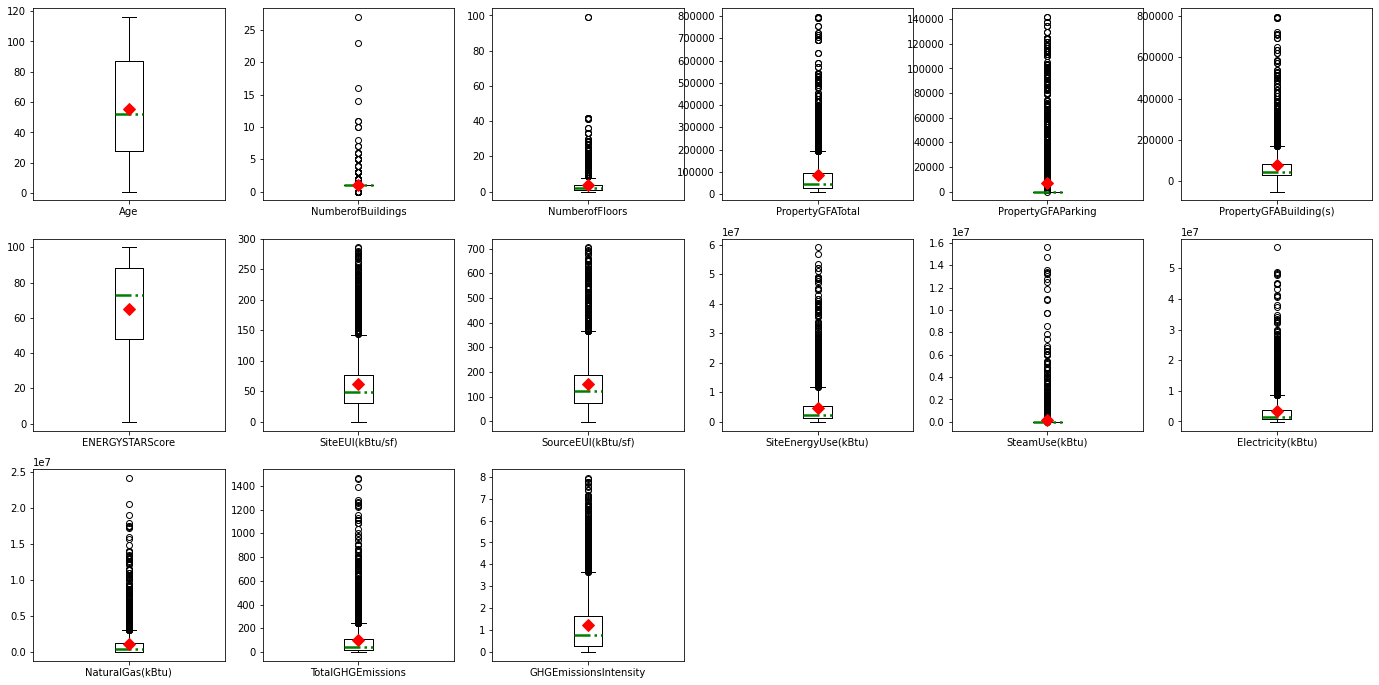

In [46]:
box_plot(df_final)

(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

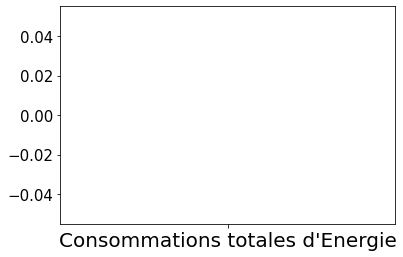

In [47]:
plt.boxplot(df_final['SiteEnergyUse(kBtu)'],showmeans=True,
            medianprops = dict(linestyle='-.', linewidth=2.5, color='green'),
            meanprops = dict(marker='D',markerfacecolor='red',markeredgecolor='red',markersize=8))
plt.xticks(ticks=[1],labels=["Consommations totales d'Energie"],fontsize=20)
plt.yticks(fontsize=15)

In [48]:
df_final.shape

(3077, 23)

<hr/>

## VI. Gestion des valeurs manquantes
<p> Ici on traite et gère les NaN. </p>

* **Gestion des Nan restant**

    - Pour les variables catégorielles (remplacement par la valeur "inconnu")

In [49]:
def nan_string_replace(dataframe):
    ''' Fonction qui prend en entrée un dataframe,
        identifie les valeurs manquantes pour les variables catégorielles,
        les remplace par la valeur "inconnu", et
        retourne le data après traitement
    '''    
    
    cat_columns = cat
    
    for col in cat_columns:
        if col=='ZipCode':
            for i in dataframe.index:
                if dataframe.loc[i,col]==np.nan:
                    street = dataframe.loc[i,'Street']
                    zipcode = dataframe[dataframe.Street==street][col].values[0]
                    dataframe.loc[i,col] = zipcode
        else:
            dataframe[col].fillna(value='inconnu', inplace=True)
    
    return dataframe

In [50]:
df_final = nan_string_replace(df_final)

    - Pour les variables quantitatives

In [51]:
def nan_float_replace(dataframe):
    ''' Fonction qui prend en entrée un dataframe,
        identifie les valeurs manquantes pour les variables numeriques,
        les remplace par la médiane de cette variable filtré par le type de batiment, et
        retourne le data après traitement
    '''    

    num_columns = var
    
    for col in num_columns:
        for categ in dataframe['BuildingType'].unique():
            mean_value = np.nanmedian(dataframe.loc[(dataframe['BuildingType']==categ),col])
            if math.isnan(mean_value):
                mean_value = np.nanmedian(dataframe[col])
            dataframe.loc[(dataframe['BuildingType']==categ),col] = dataframe.loc[(dataframe['BuildingType']==categ),col].fillna(mean_value)
            
    return dataframe

In [52]:
df_final = nan_float_replace(df_final)

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


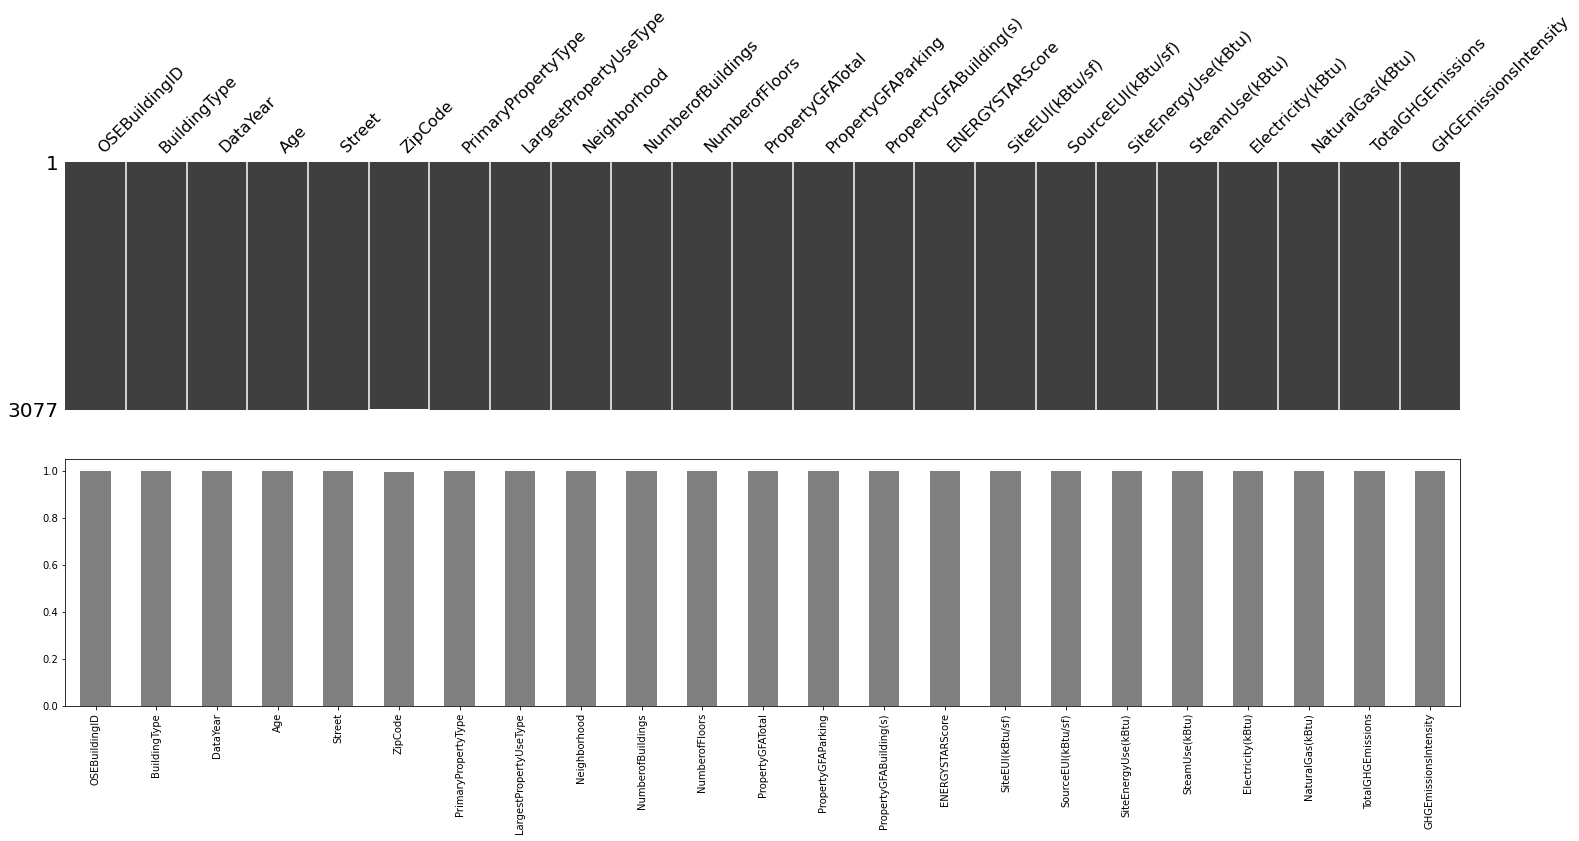

In [53]:
visu_nan(df_final)

In [54]:
df_final.shape

(3077, 23)

<hr/>

## VII.  Analyse de correlation des variables
<p> Ici on analyse de correlation des variables. </p>

In [55]:
corr = df_final.corr(method='pearson')

<AxesSubplot:>

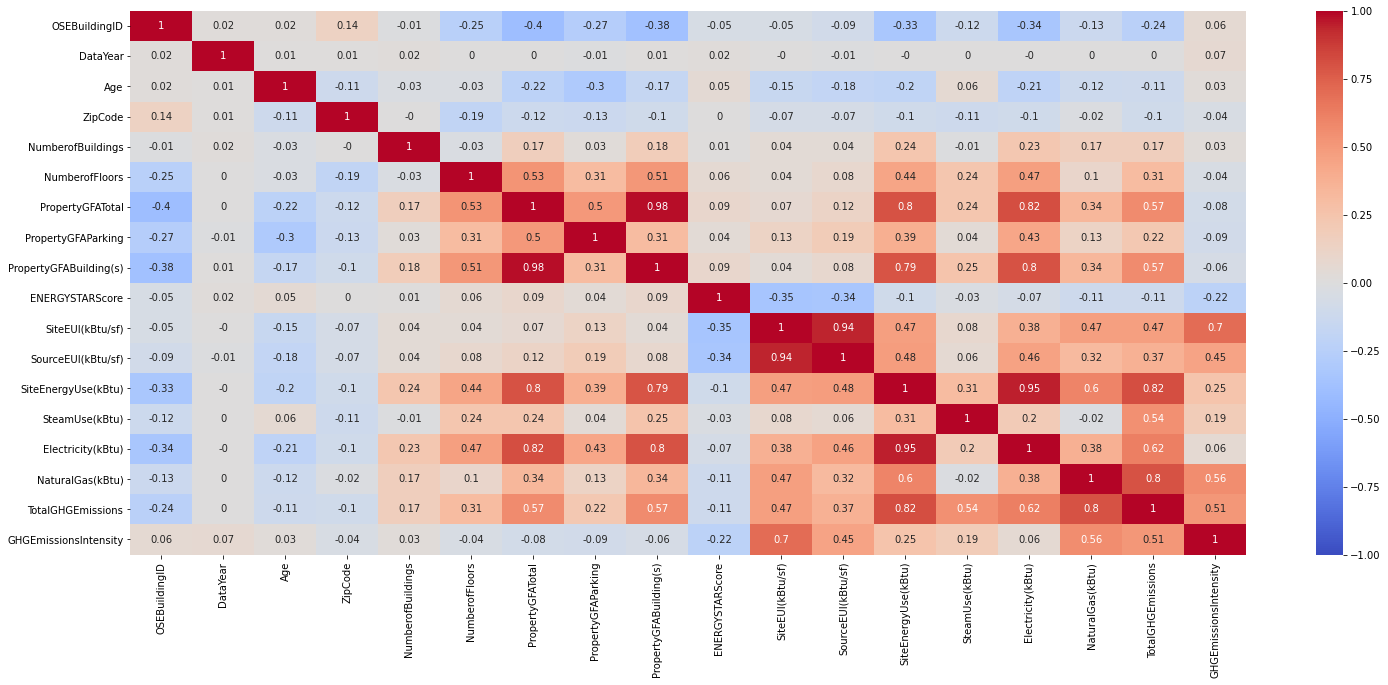

In [56]:
plt.figure(figsize=(25,10))
sns.heatmap(corr.round(2),annot=True,vmin=-1,vmax=1,cmap='coolwarm')

***Observation :***
<p> On note qu'il y a des variables très fortement correlées. On éliminera pour la suite certaines de ces variables de façon à ce que les variables restants ne présentent pas de forte corrélation et ne fausse pas la construction des modèles.</p>

In [57]:
select_col = [v for v in df_final.columns if v not in ['PropertyGFATotal','SourceEUI(kBtu/sf)','Electricity(kBtu)','NaturalGas(kBtu)']]

In [58]:
data = df_final[select_col]

In [59]:
data.shape

(3077, 19)

In [60]:
corri = df_final[[v for v in df_final.columns if v not in ['PropertyGFATotal','SourceEUI(kBtu/sf)','Electricity(kBtu)','NaturalGas(kBtu)']]].corr(method='pearson')

<AxesSubplot:>

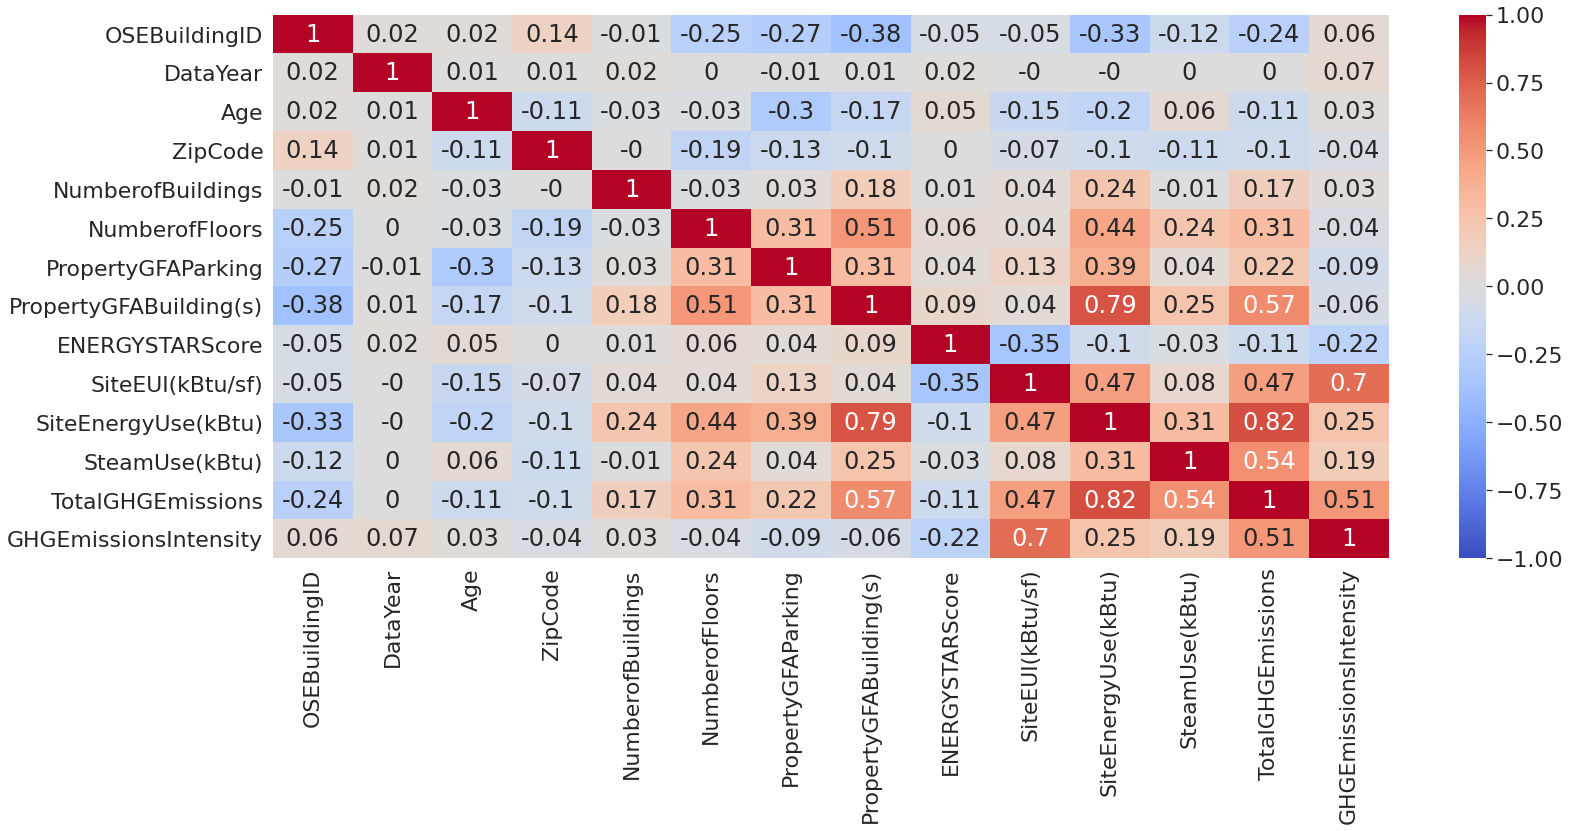

In [61]:
plt.figure(figsize=(25,10))
sns.set(font_scale=2)
sns.heatmap(corri.round(2),annot=True,vmin=-1,vmax=1,cmap='coolwarm')

<hr/>

## VII. Transformation des données
<p> Ici on sélectionne les variables et les transforme si nécessaire pour la suite. </p>

### Variables numériques

In [62]:
var = [v for v in var if v not in ['PropertyGFATotal','SourceEUI(kBtu/sf)','Electricity(kBtu)','NaturalGas(kBtu)']]

* **Observation de l'allure des variables**

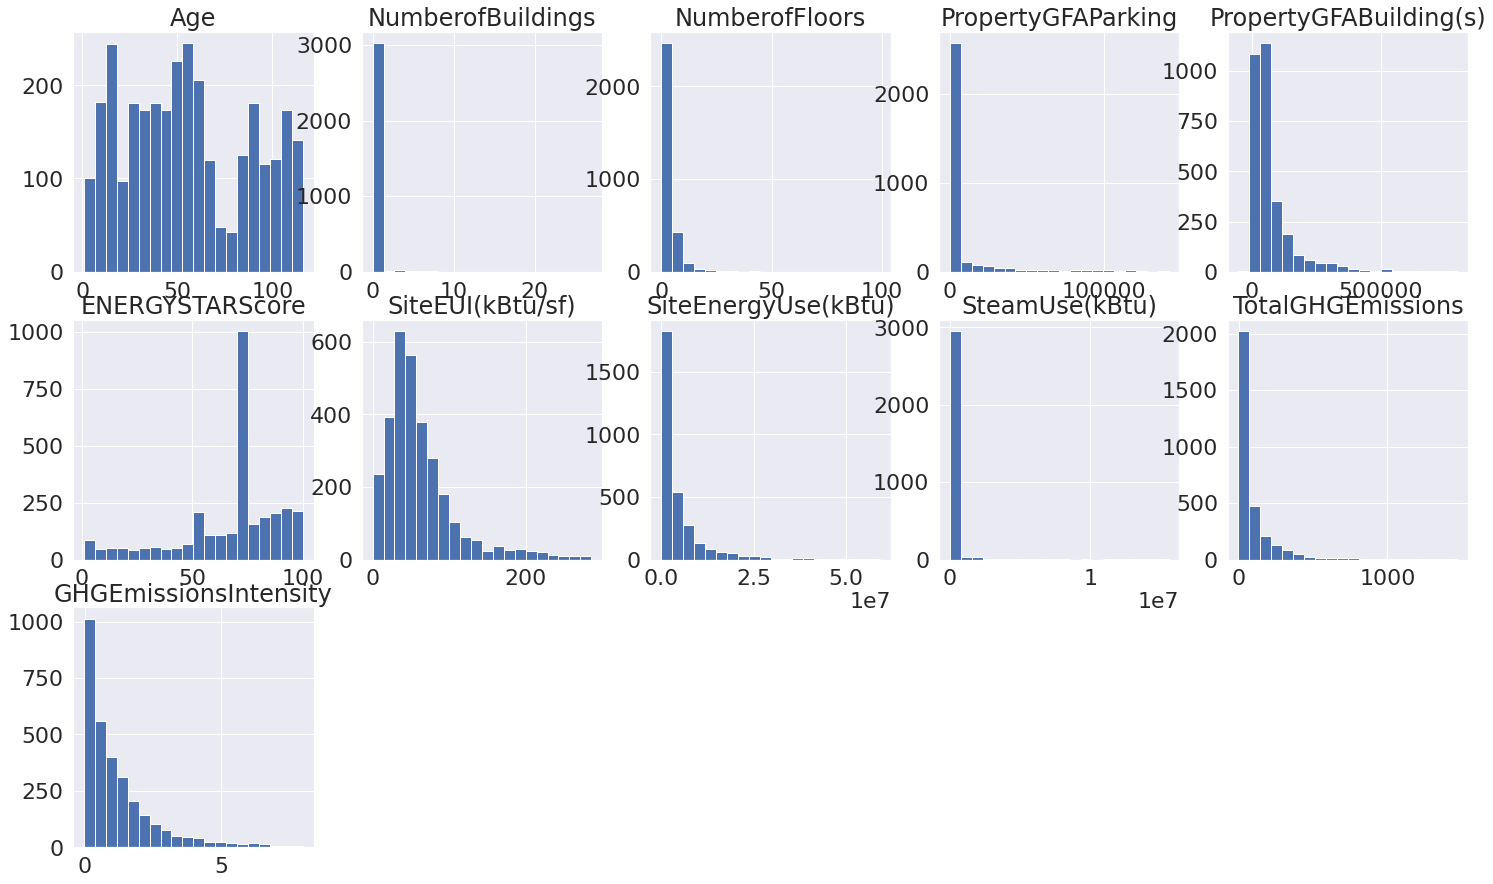

In [63]:
fig = plt.figure(figsize=(25,15))
for i in range(len(var)):
    plt.subplot(3, 5, i+1)
    plt.hist(data[var[i]],bins=20,color='b')
    plt.title(var[i])

***Observation :***
<p> On note que les variables ne sont pas dans la même ordre de grandeur => il y a nécéssité de transformer et d'uniformiser, de standardiser les données pour les étapes d'après.</p>
<p>(cela ne concernera que les données numériques) 

* **Normalisation**
<p>(Pour les variables grands : ordre de 10e2 à 10e4)</p>

In [64]:
var_to_norm = ['SiteEUI(kBtu/sf)']

In [65]:
for col in var_to_norm:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* **Transformation log**
<p>(Pour les variables trop grands : ordre supérieure ou égal à 10e5)</p>

In [66]:
var_to_log = ['PropertyGFAParking','PropertyGFABuilding(s)','SiteEnergyUse(kBtu)','SteamUse(kBtu)',
              'TotalGHGEmissions']

In [67]:
for col in var_to_log:
    data[col] = data.apply(lambda x: np.log(1 + x[col]) if np.log(1 + x[col]) > 0 else 0, axis=1)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
data.head()

,OSEBuildingID,BuildingType,DataYear,Age,Street,ZipCode,PrimaryPropertyType,LargestPropertyUseType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,2015,88.0,OLIVE WAY,98101.0,Hotel,Hotel,DOWNTOWN,1.0,12.0,0.000000,11.390023,65.0,0.378379,15.758764,14.520108,5.523179,2.64
1,2,NonResidential,2015,19.0,PINE ST,98101.0,Hotel,Hotel,DOWNTOWN,1.0,11.0,9.620129,11.390792,51.0,0.709528,15.938279,0.000000,5.577879,2.38
4,8,NonResidential,2015,35.0,LENORA ST,98121.0,Hotel,Hotel,DOWNTOWN,1.0,18.0,9.430359,11.584604,67.0,1.258594,16.512102,0.000000,6.231858,4.02
5,9,Nonresidential COS,2015,16.0,VIRGINIA ST,98101.0,Other,Police Station,DOWNTOWN,1.0,2.0,10.524037,11.003615,51.0,1.591878,16.304740,0.000000,5.722343,2.81
6,10,NonResidential,2015,89.0,9TH AVE,98101.0,Hotel,Hotel,DOWNTOWN,1.0,11.0,0.000000,11.326704,25.0,0.335651,15.648547,0.000000,5.344533,2.37


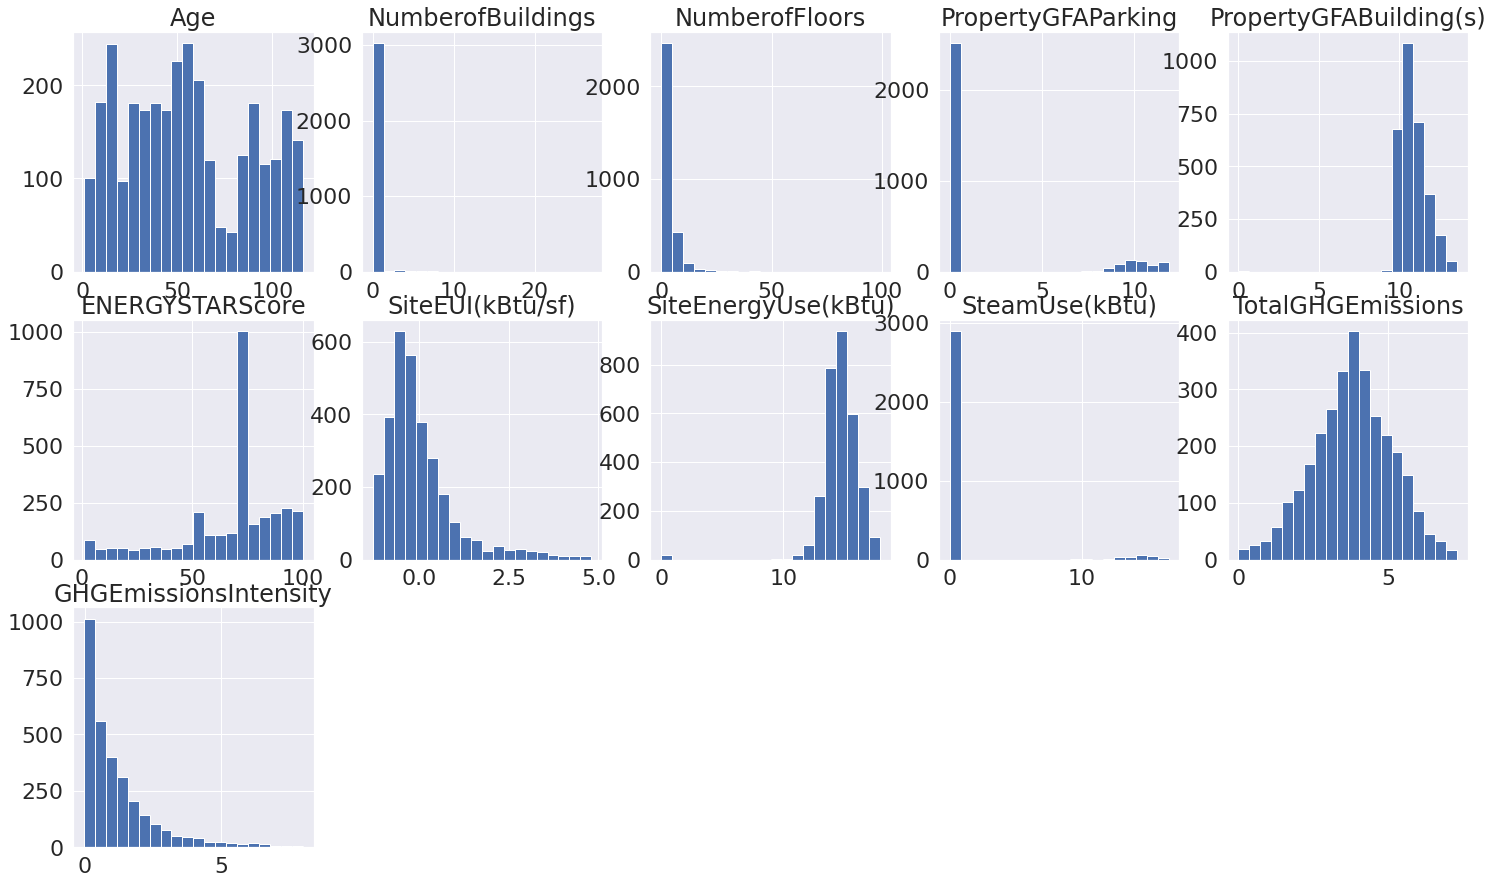

In [69]:
fig = plt.figure(figsize=(25,15))
for i in range(len(var)):
    plt.subplot(3, 5, i+1)
    plt.hist(data[var[i]],bins=20,color='b')
    plt.title(var[i])

### Variables catégorielles

* **Observation de l'allure des variables**

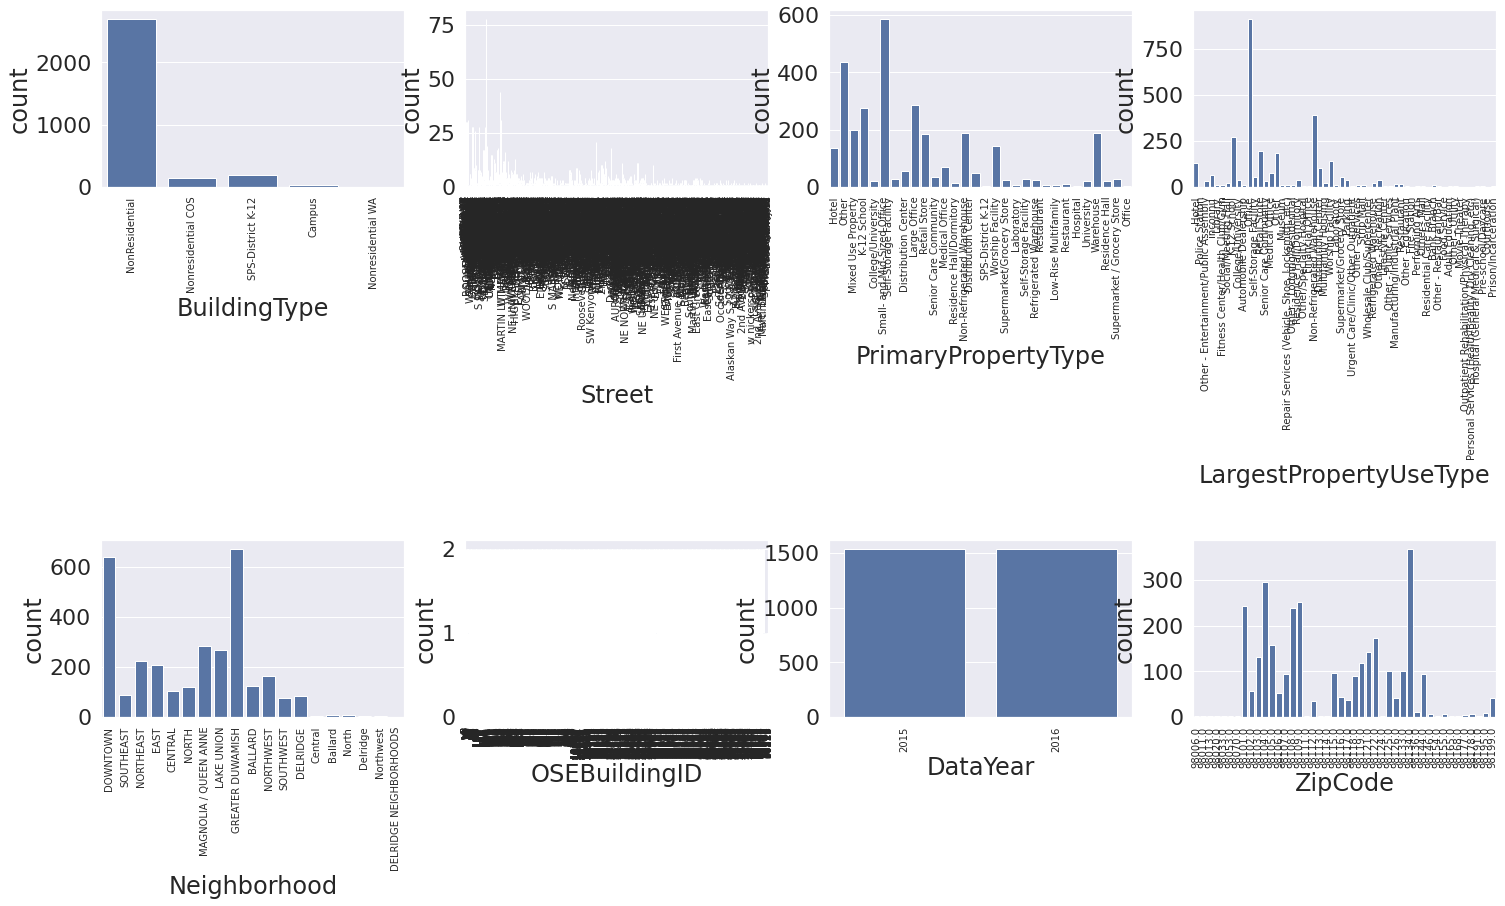

In [70]:
fig,axs = plt.subplots(2,4,figsize=(25,13),gridspec_kw={'hspace':2})

for i in range(len(cat)):
    plt.subplot(2, 4, i+1)
    sns.countplot(x=data[cat[i]],color='b')
    plt.xticks(rotation=90,fontsize=10)

Text(0.5, 1.0, 'Quartiers')

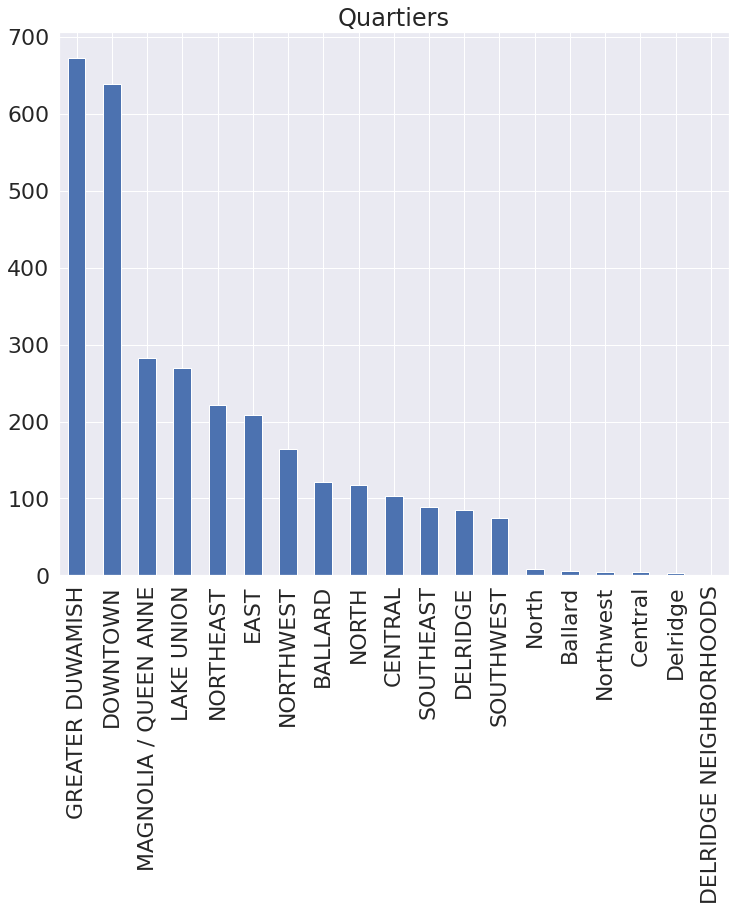

In [71]:
fig = plt.figure(figsize=(12,10))
data.Neighborhood.value_counts().plot(kind="bar")
plt.title('Quartiers')

In [72]:
data.Street.nunique()

1317

***Observation :***
<p> On note que la variable "Street" a un nombre de valeurs très élevé (2167). On décide de ne pas le garder pour la suite. </p>

In [73]:
final_data = data[data.columns.difference(['OSEBuildingID','Street','DataYear'])]

In [74]:
cat = [c for c in cat if c not in ['OSEBuildingID','Street','DataYear']]

* **Transformation onehotencoding**

In [75]:
final_data = pd.get_dummies(data=final_data, columns=cat)

In [76]:
final_data.head(3)

,Age,ENERGYSTARScore,GHGEmissionsIntensity,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,SiteEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),...,ZipCode_98146.0,ZipCode_98154.0,ZipCode_98155.0,ZipCode_98165.0,ZipCode_98168.0,ZipCode_98177.0,ZipCode_98178.0,ZipCode_98191.0,ZipCode_98195.0,ZipCode_98199.0
0,88.0,65.0,2.64,1.0,12.0,11.390023,0.000000,0.378379,15.758764,14.520108,...,0,0,0,0,0,0,0,0,0,0
1,19.0,51.0,2.38,1.0,11.0,11.390792,9.620129,0.709528,15.938279,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,35.0,67.0,4.02,1.0,18.0,11.584604,9.430359,1.258594,16.512102,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [77]:
final_data.shape

(3077, 165)

In [78]:
df_final[select_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3077 entries, 0 to 3317
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3077 non-null   int64  
 1   BuildingType            3077 non-null   object 
 2   DataYear                3077 non-null   int64  
 3   Age                     3077 non-null   float64
 4   Street                  3077 non-null   object 
 5   ZipCode                 3064 non-null   float64
 6   PrimaryPropertyType     3077 non-null   object 
 7   LargestPropertyUseType  3077 non-null   object 
 8   Neighborhood            3077 non-null   object 
 9   NumberofBuildings       3077 non-null   float64
 10  NumberofFloors          3077 non-null   float64
 11  PropertyGFAParking      3077 non-null   int64  
 12  PropertyGFABuilding(s)  3077 non-null   int64  
 13  ENERGYSTARScore         3077 non-null   float64
 14  SiteEUI(kBtu/sf)        3077 non-null   

In [79]:
df_final['SiteEnergyUse(kBtu)'].mean()

4849347.309667598